# Deterministic fitting of epidemiological models on Italian COVID-19 cases

All the following models are fitted on disjoint windows of 7 days each.
After fitting, predictions are plotted for the entire dataset (about 1 year), RMSE is computed as a (crude) evaluation metric and the fitted parameters are exported as csv in order to be used as seeds for the Bayesian melding.

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd

import models

def rmse(true, pred):
    out = 0
    for i in range(len(true)):
        out += (true[i] - pred[i]) ** 2
    return (out / len(true)) ** 0.5

## SIR model

                 data stato  ricoverati_con_sintomi  terapia_intensiva  \
0 2020-02-24 18:00:00   ITA                     101                 26   
1 2020-02-25 18:00:00   ITA                     114                 35   
2 2020-02-26 18:00:00   ITA                     128                 36   
3 2020-02-27 18:00:00   ITA                     248                 56   
4 2020-02-28 18:00:00   ITA                     345                 64   

   totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
0                   127                      94              221   
1                   150                     162              311   
2                   164                     221              385   
3                   304                     284              588   
4                   409                     412              821   

   variazione_totale_positivi  nuovi_positivi  dimessi_guariti  ...  tamponi  \
0                           0             221                1  ..

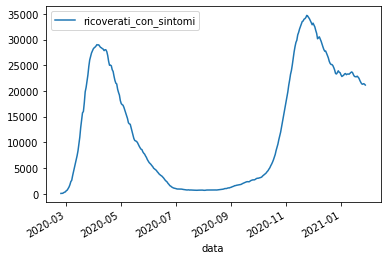

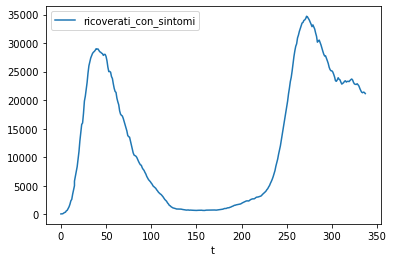

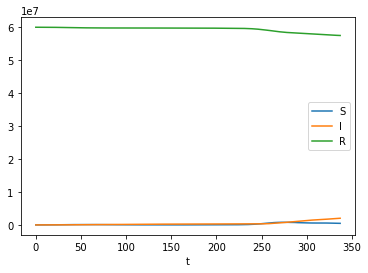

In [2]:
df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", parse_dates=["data"]) # 28/01/2021. Entire dataset.

print(df.head())

df.plot.line("data", "ricoverati_con_sintomi")

df["t"] = (df["data"] - df["data"].loc[0]) // np.timedelta64(1, "D")

print(df[["data", "t"]].head())

df.plot.line("t", "ricoverati_con_sintomi")
dataset = pd.DataFrame() # Dataset containing only the relevant fields for the SIR model.
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"] + df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R"])

print(dataset.head())


In order for curve_fit to work correctly, inputs and outputs need to be passed as lists. To solve this problem, the `Model.f(...)` proxy needs to be used along with a sequence of inputs from $0$ to $t$.

In [3]:
my_sir = models.SIR()

means = {}
variances = {}
for i in range(len(dataset) // 7):
    print("Fitting window {}-{}...".format(i * 7, (i+1) * 7))
    x_data = np.array([j for j in range(7)], dtype=np.uint8)
    y_data = np.zeros((7, 3), dtype=np.float)
    for j in range(7):
        y_data[j,0] = dataset["s"].iloc[i * 7 + j]
        y_data[j,1] = dataset["i"].iloc[i * 7 + j]
        y_data[j,2] = dataset["r"].iloc[i * 7 + j]
        
    initial_guess = [dataset["s"].iloc[i * 7], dataset["i"].iloc[i * 7], dataset["r"].iloc[i * 7], 0.5, 0.5]
    vals, confidences = curve_fit(my_sir.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, 1, 1]))
    keys = my_sir.get_input_keys()
    for k in range(len(keys)):
        my_sir.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])

Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273

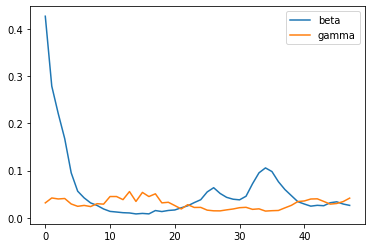

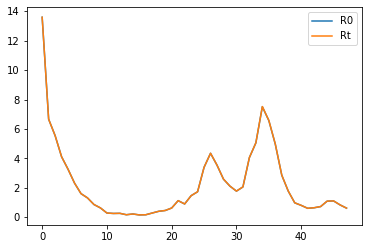

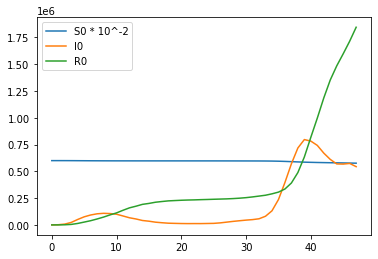

In [10]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.legend(["beta", "gamma"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])

plt.legend(["S0 * 10^-2", "I0", "R0"])

plt.show()

In [11]:
predictions = {}
in_keys = my_sir.get_input_keys()
out_keys = my_sir.get_output_keys()
for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        my_sir.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_sir.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 1140.272443138702
RMS on I0: 2076.2370731915257
RMS on R0: 2073.615905364144
Total RMSE: 5290.125421694372


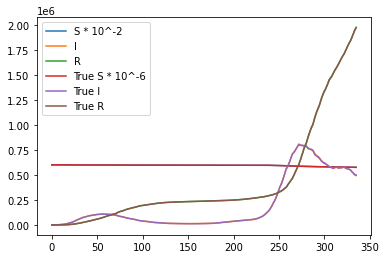

In [14]:
plt.plot(range(0, len(predictions["S"])), np.array(predictions["S"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(predictions["I"])), predictions["I"])
plt.plot(range(0, len(predictions["R"])), predictions["R"])
plt.plot(range(0, len(predictions["S"])), np.array(dataset["s"].iloc[:len(predictions["S"])], dtype=np.float) * 10**-2)
plt.plot(range(0, len(predictions["I"])), dataset["i"].iloc[:len(predictions["S"])])
plt.plot(range(0, len(predictions["R"])), dataset["r"].iloc[:len(predictions["S"])])


plt.legend(["S * 10^-2", "I", "R", "True S * 10^-6", "True I", "True R"])

plt.show()

In [15]:
print(means)

{'S0': [59999776.00523314, 59998008.374203265, 59991124.611590244, 59972127.82019117, 59935516.400573075, 59898153.51276111, 59868045.38111232, 59840794.68164808, 59818570.12457735, 59800415.349158525, 59788106.04910009, 59779945.97505981, 59774050.25427434, 59769906.11222923, 59766823.156311944, 59764778.379212365, 59762649.6942262, 59761288.36914195, 59759615.465686664, 59758241.68944345, 59756850.25029957, 59755445.55458976, 59753780.67492503, 59751908.52369144, 59749252.70641894, 59746120.22494117, 59739849.99666236, 59731029.257413685, 59721223.39053927, 59711459.204630524, 59700708.245261826, 59689194.16673179, 59673678.08372076, 59642075.574293405, 59578389.245520055, 59457425.17772592, 59269256.53985088, 59038371.82653274, 58793357.64108005, 58569622.73067262, 58400171.2040872, 58261153.585482, 58145049.93549595, 58036205.84027275, 57946651.358433425, 57835175.20440283, 57711775.212144494, 57611657.00266111], 'I0': [209.7896311122416, 1754.5339402107118, 7660.726205683863, 2313

In [16]:
sir_params = pd.DataFrame(means)
sir_params = sir_params.reset_index()
sir_params = sir_params.rename(columns={"index":"t"})
dates = (sir_params["t"] * 7).to_list()
sir_params["data"] = df["data"][dates].to_list()


print(sir_params.head())

sir_params.to_csv("sir_params_weekly.csv")

   t            S0            I0            R0      beta     gamma  \
0  0  5.999978e+07    209.789631     11.922912  0.426895  0.031425   
1  1  5.999801e+07   1754.533940    228.390876  0.278800  0.041829   
2  2  5.999112e+07   7660.726206   1216.327838  0.220608  0.039746   
3  3  5.997213e+07  23135.456731   4747.701848  0.167516  0.040703   
4  4  5.993552e+07  50833.947510  13657.923259  0.095110  0.029127   

                 data  
0 2020-02-24 18:00:00  
1 2020-03-02 18:00:00  
2 2020-03-09 18:00:00  
3 2020-03-16 17:00:00  
4 2020-03-23 17:00:00  


# SIRD fitting

     i   r   d         s
t                       
0  221   1   7  59999771
1  311   1  10  59999678
2  385   3  12  59999600
3  588  45  17  59999350
4  821  46  21  59999112


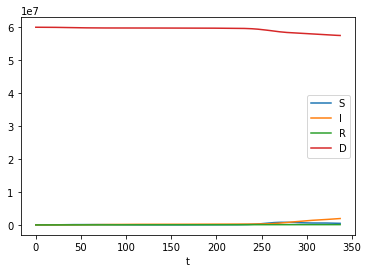

In [17]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"]= df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"] + dataset["d"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R", "D"])

print(dataset.head())

In [18]:
my_sird = models.SIRD()

means = {}
variances = {}
for i in range(len(dataset) // 7):
    print("Fitting window {}-{}...".format(i * 7, (i+1) * 7))
    x_data = np.array([j for j in range(7)], dtype=np.uint8)
    y_data = np.zeros((7, 4), dtype=np.float)
    for j in range(7):
        y_data[j,0] = dataset["s"].iloc[i * 7 + j]
        y_data[j,1] = dataset["i"].iloc[i * 7 + j]
        y_data[j,2] = dataset["r"].iloc[i * 7 + j]
        y_data[j,3] = dataset["d"].iloc[i * 7 + j]

    initial_guess = [dataset["s"].iloc[i * 7], dataset["i"].iloc[i * 7], dataset["r"].iloc[i * 7], dataset["d"].iloc[i * 7], 0.5, 0.5, 0]
    vals, confidences = curve_fit(my_sird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, 1, 1, 1]))
    keys = my_sird.get_input_keys()
    for k in range(len(keys)):
        my_sird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273

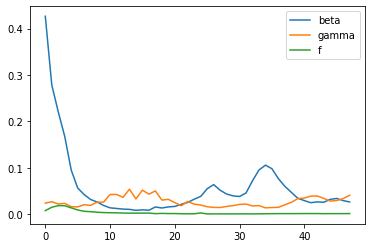

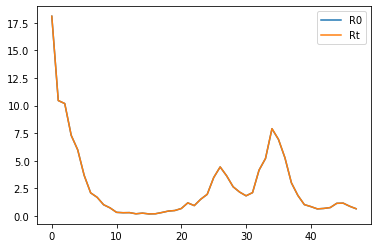

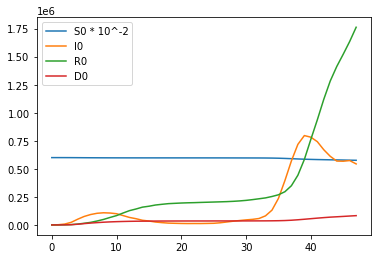

In [19]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["f"])), means["f"])

plt.legend(["beta", "gamma", "f"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "I0", "R0", "D0"])

plt.show()

In [20]:
predictions = {}
in_keys = my_sird.get_input_keys()
out_keys = my_sird.get_output_keys()
for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        my_sird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_sird.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 1140.1318536238105
RMS on I0: 2076.199383149337
RMS on R0: 2044.8081681538015
RMS on D0: 56.65176233869106
Total RMSE: 5317.79116726564


In [21]:
print(means["f"])

[0.007338073802669641, 0.01463787727585705, 0.01813184904491033, 0.01787564710963767, 0.01332711895571489, 0.008861194279910369, 0.005905025706585276, 0.005058132329128287, 0.003994106444714471, 0.003121960157977458, 0.002822653347115386, 0.002635299943339842, 0.002179405322135542, 0.0018241463811416274, 0.0019138515038329082, 0.0019939049522451338, 0.002071783639079825, 0.0008342322638515157, 0.0013870380182416512, 0.0010193454730011236, 0.0010975313107024144, 0.0006355754299324446, 0.0005334975742099893, 0.0005143301673917453, 0.0023749027571179538, 0.0002639616182445304, 0.0002872371416814739, 0.00033419291106346016, 0.0002811795294536583, 0.0003277178304850001, 0.000400612219138073, 0.00039223070712530084, 0.0002766058356132799, 0.00041931134573022, 0.0006365485758986829, 0.0008023092839030866, 0.0008824282915117725, 0.0009454660172816001, 0.0009269164254164622, 0.0009612127436351554, 0.0010319057390259147, 0.0009857036455168159, 0.0010355087577723432, 0.0007928832303815712, 0.0008

In [22]:
sird_params = pd.DataFrame(means)
sird_params = sird_params.reset_index()
sird_params = sird_params.rename(columns={"index":"t"})
dates = (sird_params["t"] * 7).to_list()
sird_params["data"] = df["data"][dates].to_list()


print(sird_params.head())

sird_params.to_csv("sird_params_weekly.csv")

   t            S0            I0           R0           D0      beta  \
0  0  5.999978e+07    209.576040     3.208088     9.383669  0.426712   
1  1  5.999801e+07   1752.552185   179.821274    53.119676  0.278601   
2  2  5.999113e+07   7661.574778   717.909924   497.067978  0.220613   
3  3  5.997213e+07  23140.656602  2650.198165  2086.572202  0.167559   
4  4  5.993552e+07  50839.706687  7557.099365  6086.343162  0.095144   

      gamma         f                data  
0  0.023566  0.007338 2020-02-24 18:00:00  
1  0.026637  0.014638 2020-03-02 18:00:00  
2  0.021655  0.018132 2020-03-09 18:00:00  
3  0.022950  0.017876 2020-03-16 17:00:00  
4  0.015883  0.013327 2020-03-23 17:00:00  


# Hidden SEIRD

In [23]:
my_seird = models.HiddenSEIRD()

means = {}
variances = {}
for i in range(len(dataset) // 7):
    print("Fitting window {}-{}...".format(i * 7, (i+1) * 7))
    x_data = np.array([j for j in range(7)], dtype=np.uint8)
    y_data = np.zeros((7, 4), dtype=np.float)
    for j in range(7):
        y_data[j,0] = dataset["s"].iloc[i * 7 + j]
        y_data[j,1] = dataset["i"].iloc[i * 7 + j]
        y_data[j,2] = dataset["r"].iloc[i * 7 + j]
        y_data[j,3] = dataset["d"].iloc[i * 7 + j]

    initial_guess = [dataset["s"].iloc[i * 7], 2 * dataset["i"].iloc[i * 7], dataset["i"].iloc[i * 7], dataset["r"].iloc[i * 7], dataset["d"].iloc[i * 7], 0.5, 0.5, 0.5, 0, 0]
    vals, confidences = curve_fit(my_seird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, 1, 1, 1, 0.0001, 1]), maxfev=10000)
    keys = my_seird.get_input_keys()
    for k in range(len(keys)):
        my_seird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273

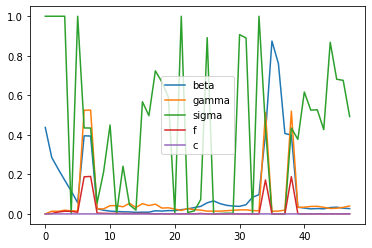

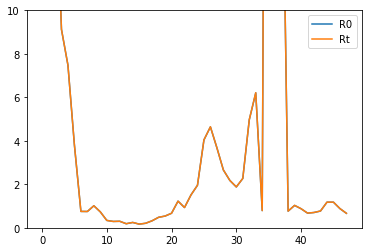

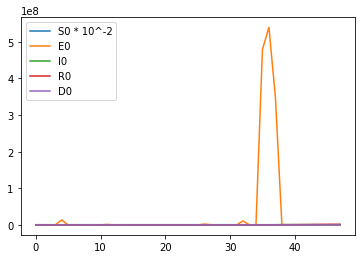

In [24]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.plot(range(0, len(means["f"])), means["f"])
plt.plot(range(0, len(means["c"])), means["c"])

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.ylim([0, 10])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "E0", "I0", "R0", "D0"])

plt.show()

In [25]:
print(means["E0"])

[140.4307803247645, 501.4664428489012, 1412.8241660762267, 4285.2395629231105, 13512922.268384743, 4175.197182772732, 186373.9207846882, 207231.92006008368, 50608.9334684882, 8490.078172127201, 1124.0736096829885, 1463519.3623523947, 2436.1778351816797, 10872.105390544602, 16015.398506545727, 679.6435816242928, 9.784059319715581, 3.0942564276782966e-08, 1.387446244883289e-06, 0.004747442468536421, 35224.60275007142, 84.14220399260768, 43831.143994096536, 26654.393994656257, 7296.4154587953135, 368.9633914780735, 2158305.3770560585, 731949.5204208938, 424192.2665103736, 514049.40660264116, 1404.142367584758, 1324.478885763615, 10798677.16353647, 5674.166091038517, 268005.9251437261, 479395252.3894444, 539983488.9500636, 349286658.2073529, 1435567.9205527266, 66307.58131523231, 20795.56915391355, 13783.033733288516, 18402.086053142946, 28488.50516144543, 9957.45293720865, 21830.171996744277, 19247.090727952393, 18526.44136173113]


In [26]:
predictions = {}
in_keys = my_seird.get_input_keys()
out_keys = my_seird.get_output_keys()
for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        my_seird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_seird.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 121892.43602864133
RMS on I0: 36305.25801134019
RMS on R0: 182396.49242304883
RMS on D0: 69092.69747048678
Total RMSE: 409686.88393351715


As it can be seen from the plots, the optimizer sometimes decides to make the number of exposed people rise substantially, in order to fit the known data. This is due to the complete freedom both on the exposed compartment and the rates which increase it (beta and sigma).

The fitting process is repeated after forcing a value for sigma close to the true incubation rate described in literature (8.2 to 15.6 days, CI = 97.5%, https://pubmed.ncbi.nlm.nih.gov/32150748/).

In [27]:
my_seird = models.HiddenSEIRD()

means = {}
variances = {}
for i in range(len(dataset) // 7):
    print("Fitting window {}-{}...".format(i * 7, (i+1) * 7))
    x_data = np.array([j for j in range(7)], dtype=np.uint8)
    y_data = np.zeros((7, 4), dtype=np.float)
    for j in range(7):
        y_data[j,0] = dataset["s"].iloc[i * 7 + j]
        y_data[j,1] = dataset["i"].iloc[i * 7 + j]
        y_data[j,2] = dataset["r"].iloc[i * 7 + j]
        y_data[j,3] = dataset["d"].iloc[i * 7 + j]

    initial_guess = [dataset["s"].iloc[i * 7], 2 * dataset["i"].iloc[i * 7], dataset["i"].iloc[i * 7], dataset["r"].iloc[i * 7], dataset["d"].iloc[i * 7], 0.5, 0.5, 1 / 12, 0, 0]
    vals, confidences = curve_fit(my_seird.f, x_data, y_data.flatten(), initial_guess, bounds=([0, 0, 0, 0, 0, 0, 0, 1 / 15.6, 0, 0], [dataset["s"].iloc[i * 7], dataset["s"].iloc[i * 7], dataset["s"].iloc[i * 7], dataset["s"].iloc[i * 7], dataset["s"].iloc[i * 7], 1, 1, 1 / 8.2, 0.0001, 1]), maxfev=10000)
    keys = my_seird.get_input_keys()
    for k in range(len(keys)):
        my_seird.input_params[keys[k]] = vals[k]
        
    for k in range(len(keys)):
        if keys[k] not in means:
            means[keys[k]] = []
        means[keys[k]].append(vals[k])
        if keys[k] not in variances:
            variances[keys[k]] = []
        variances[keys[k]].append(confidences[k])


Fitting window 0-7...
Fitting window 7-14...
Fitting window 14-21...
Fitting window 21-28...
Fitting window 28-35...
Fitting window 35-42...
Fitting window 42-49...
Fitting window 49-56...
Fitting window 56-63...
Fitting window 63-70...
Fitting window 70-77...
Fitting window 77-84...
Fitting window 84-91...
Fitting window 91-98...
Fitting window 98-105...
Fitting window 105-112...
Fitting window 112-119...
Fitting window 119-126...
Fitting window 126-133...
Fitting window 133-140...
Fitting window 140-147...
Fitting window 147-154...
Fitting window 154-161...
Fitting window 161-168...
Fitting window 168-175...
Fitting window 175-182...
Fitting window 182-189...
Fitting window 189-196...
Fitting window 196-203...
Fitting window 203-210...
Fitting window 210-217...
Fitting window 217-224...
Fitting window 224-231...
Fitting window 231-238...
Fitting window 238-245...
Fitting window 245-252...
Fitting window 252-259...
Fitting window 259-266...
Fitting window 266-273...
Fitting window 273

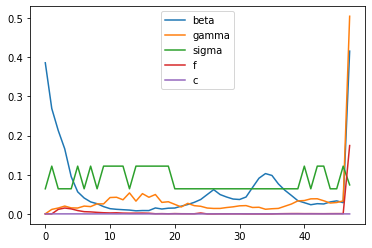

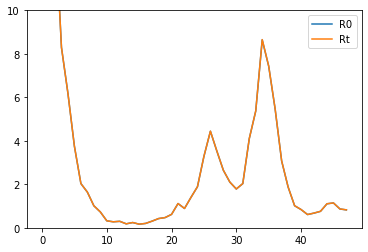

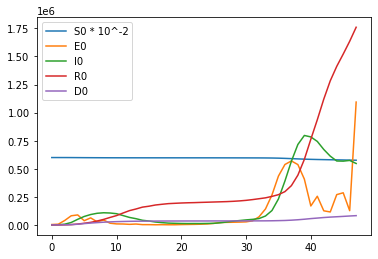

In [28]:
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.plot(range(0, len(means["f"])), means["f"])
plt.plot(range(0, len(means["c"])), means["c"])

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.ylim([0, 10])
plt.show()

plt.plot(range(0, len(means["S0"])), np.array(means["S0"], dtype=np.float) * 10**-2)
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.plot(range(0, len(means["D0"])), means["D0"])


plt.legend(["S0 * 10^-2", "E0", "I0", "R0", "D0"])

plt.show()

In [29]:
print(means["E0"])

[3442.18664121557, 6442.195533444431, 39744.19480350289, 81375.34823307833, 89107.44803260945, 37437.57747447198, 62762.464749909916, 27728.50596779882, 43140.4566278823, 15135.792135665752, 9003.965836812271, 8170.822550635928, 5141.728593696994, 7817.804570987308, 2596.156041146322, 2490.3078506237157, 1254.199994625543, 2039.511180960272, 1296.3144880887496, 1434.0361188193783, 3070.197917297711, 3992.4680113690406, 4866.03880563287, 6336.751778566314, 8309.955179911325, 13364.505952674353, 21149.58614662395, 22905.279322398856, 23680.389890945688, 25072.406098141208, 27202.338374926054, 36467.48583063772, 72215.69912031162, 142368.81575498093, 266772.26011307427, 435029.82343909127, 538170.6897699423, 569706.4495394644, 537448.2756018733, 407922.4654053896, 168741.7474192694, 255399.74291027748, 125669.6289240839, 115313.96505617056, 269874.46100853663, 286194.40846999636, 126867.609929588, 1094117.9655289862]


In [30]:
predictions = {}
in_keys = my_seird.get_input_keys()
out_keys = my_seird.get_output_keys()
for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        my_seird.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = my_seird.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 48792.67688401735
RMS on I0: 47090.66116939176
RMS on R0: 60092.71081086224
RMS on D0: 24360.073416085153
Total RMSE: 180336.1222803565


In [31]:
seird_params = pd.DataFrame(means)
seird_params = seird_params.reset_index()
seird_params = seird_params.rename(columns={"index":"t"})
dates = (seird_params["t"] * 7).to_list()
seird_params["data"] = df["data"][dates].to_list()


print(seird_params.head())

seird_params.to_csv("hidden_seird_params_weekly.csv")

   t            S0            E0            I0           R0           D0  \
0  0  5.999974e+07   3442.186641     80.061002    32.336543    18.571429   
1  1  5.999796e+07   6442.195533   1471.552915   297.681732   168.844577   
2  2  5.999083e+07  39744.194804   6701.928215   923.830592   700.548113   
3  3  5.997201e+07  81375.348233  21687.435456  2898.803397  2328.522257   
4  4  5.993549e+07  89107.448033  49902.785501  7641.182960  6167.995715   

       beta     gamma     sigma       c             f                data  
0  0.385644  0.000313  0.064107  0.0001  1.560026e-18 2020-02-24 18:00:00  
1  0.268964  0.011499  0.121951  0.0001  1.558075e-06 2020-03-02 18:00:00  
2  0.212813  0.015036  0.064103  0.0001  1.160033e-02 2020-03-09 18:00:00  
3  0.166112  0.020029  0.064103  0.0001  1.503983e-02 2020-03-16 17:00:00  
4  0.095095  0.015389  0.064103  0.0001  1.284764e-02 2020-03-23 17:00:00  
